# Sampling from a transformed parameter space

This example shows you how to run (and compare) Bayesian inference using a transformed parameter space.

Searching in a transformed space can improve performance (and robustness) of many sampling methods, and make some methods applicable to problems that cannot otherwise be tackled.

Unlike transforming error measures, for probability density functions (PDFs), in order to make sure the probability for any arbitrary interval within the PDFs conserves between parameter transformations, we cannot simply [transform the model parameters by using a model wrapper](../optimisation/transformed-parameters-model-wrapper.ipynb).
We need what is called the Jacobian adjustment to 'correct' the transformed PDFs or rather to ensure this conservation (as explained in [pints.TransformedLogPDF](https://pints.readthedocs.io/en/latest/transformations.html#pints.TransformedLogPDF)).
An example notebook [here](./transformation-with-and-without-jacobian.ipynb) shows how things can go wrong with a naive wrapper without the Jacobian adjustment.
All of these (easy-to-miss) adjustments are done behind the scenes by our [pints.Transformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.Transformation) and [pints.MCMCController](https://pints.readthedocs.io/en/latest/mcmc_samplers/running.html#pints.MCMCController) as shown in this example.

We start by loading a ``pints.Forwardmodel`` implementation, in this case a [logistic model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html).

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Set some random seed so this notebook can be reproduced
np.random.seed(10)

# Load a forward model
model = toy.LogisticModel()

We then define some parameters and set up the problem for the Bayesian inference.

In [2]:
# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.001, 10, noise*0.1],
    [1.0, 1000, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In this example, we will pick some considerably difficult starting points for the MCMC chains.

In [3]:
# Choose starting points for 3 mcmc chains
xs = [
    [0.7, 20, 2],
    [0.005, 900, 100],
    [0.01, 100, 500],
]

Let's run an [Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_bardenet_ac_mcmc.html) without doing any parameter transformation to check its performance.

Running...
Done!


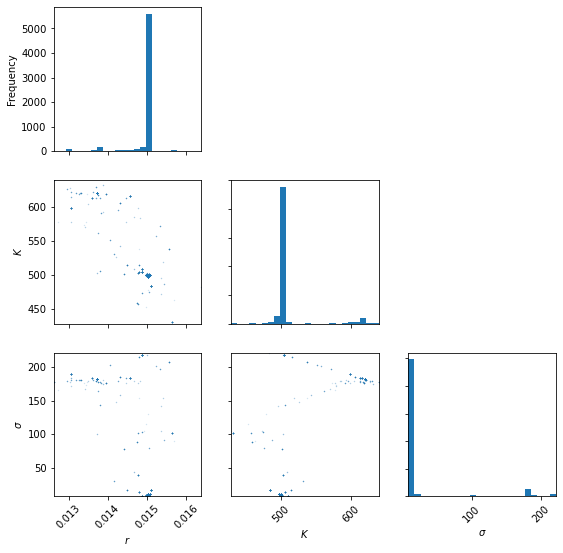

In [4]:
# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False, parameter_names=[r'$r$', r'$K$', r'$\sigma$'])

# Show graphs
plt.show()

The MCMC samples are not ideal, because we've started the MCMC run from some difficult starting points.
We can use [MCMCSummary](https://pints.readthedocs.io/en/latest/mcmc_samplers/summary_mcmc.html) to inspect the efficiency of the MCMC run.

In [5]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.01    0.00    0.01    0.01    0.02    0.02    0.02     1.24    325.81  155.11
k        506.52  29.30   497.38  498.93  499.28  499.68  619.66   1.24    319.67  152.18
sigma    26.15   50.61   8.88    9.25    9.42    9.62    190.10   1.57    291.89  138.95


Now, we create a create a [pints.Transformation](https://pints.readthedocs.io/en/latest/transformations.html#pints.Transformation) object for log-transformation and re-run the MCMC to see if it makes any difference.

Running...
Done!


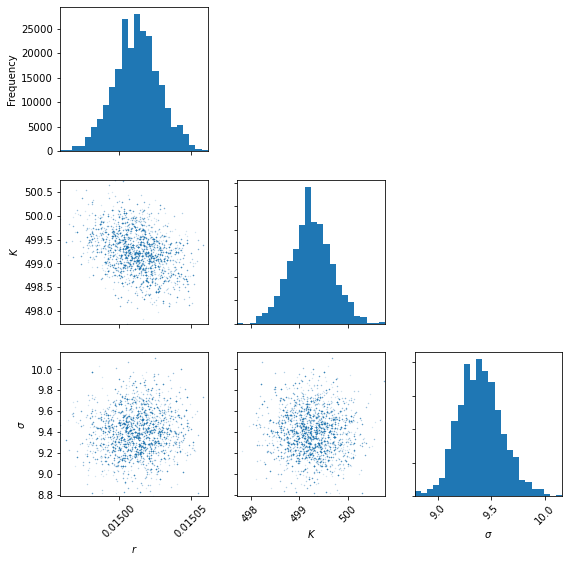

In [6]:
# Create parameter transformation
transform = pints.LogTransformation(n_parameters=len(xs[0]))

# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs,
                            method=pints.HaarioBardenetACMC,
                            transform=transform)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False, parameter_names=[r'$r$', r'$K$', r'$\sigma$'])

# Show graphs
plt.show()

The MCMC samples using parameter transformation looks very similar to the one in [another example notebook](./adaptive-covariance-haario-bardenet.ipynb) which we had some good starting points and without parameter transformation.
This is a good sign! It suggests the transformation did not mess anything up.

Now we check the efficiency again:

In [7]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.02    0.00    0.01    0.02    0.02    0.02    0.02     1.01    452.24  185.81
k        499.25  0.43    498.40  498.97  499.24  499.51  500.11   1.01    427.07  175.47
sigma    9.40    0.20    9.01    9.26    9.39    9.52    9.83     1.01    445.93  183.22


With the log-transformation on the parameters, even when using the same method, the same data and the same initial positions, we get much better performance than in the untransformed case.